In [1]:
!pip install geopandas rasterio contextily pulp shapely

In [40]:
import sys, os

# ensure Python can see your MILP folder
sys.path.append(os.path.abspath("../"))  # one level up from your notebook

# now import the function
import MILP.distance_optimizer
import importlib
importlib.reload(MILP.distance_optimizer)  # reloads updated .py file
from MILP.distance_optimizer import optimize_shade_placement


import pandas as pd
import geopandas as gpd
import numpy as np
import contextily as cx
import matplotlib.pyplot as plt
from pulp import *


n:  222  p:  94
dist_stats:  Candidate distances stats (upper tri) — min: 2.47 m, max: 7831.23 m, mean: 2477.40 m, median: 2372.62 m
 
public_stats:  Public distances stats — min: 32.40 m, max: 8537.86 m, mean: 2785.50 m, median: 2655.74 m

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/urvibhuwania/miniconda3/lib/python3.13/site-packages/pulp/apis/../solverdir/cbc/osx/i64/cbc /var/folders/wl/c3pz93w50hz8v01l8clvl_qc0000gn/T/2e8bb5b2ad23459fa0dce920bc60f186-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/wl/c3pz93w50hz8v01l8clvl_qc0000gn/T/2e8bb5b2ad23459fa0dce920bc60f186-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 73599 COLUMNS
At line 295156 RHS
At line 368751 BOUNDS
At line 393505 ENDATA
Problem MODEL has 73594 rows, 24753 columns and 171939 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value i

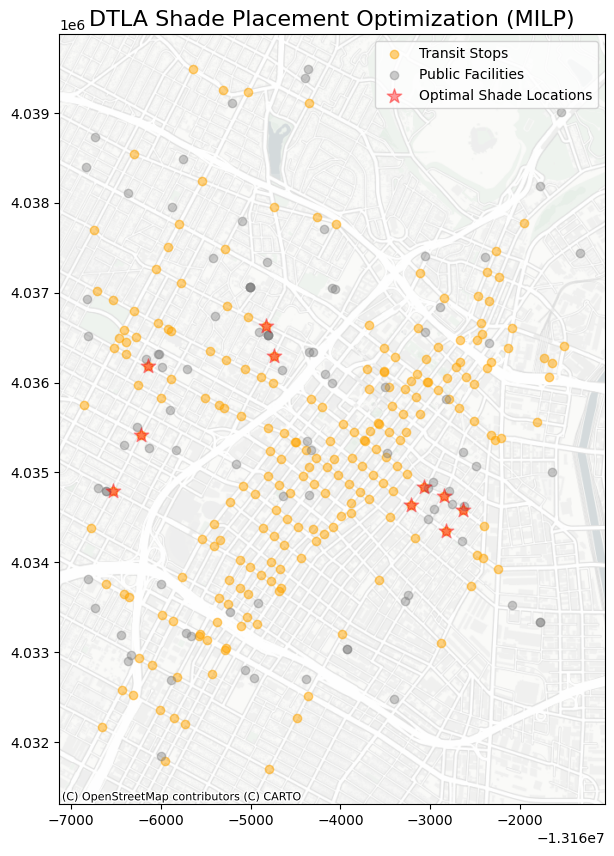

In [41]:
# --- Load DTLA data ---
bus_stops = gpd.read_file("../../461/data/bus_stops.geojson").to_crs(3857)
major_transit_stops_dtla = gpd.read_file("../../data/preprocessed/la_major_transit_stops_dtla.geojson").to_crs(3857)
schools_dtla = gpd.read_file("../../data/preprocessed/la_schools_dtla.geojson").to_crs(3857)
hospitals_dtla = gpd.read_file("../../data/preprocessed/la_hospitals_clinics_dtla.geojson").to_crs(3857)
food_dtla = gpd.read_file("../../data/preprocessed/la_food_assistance_dtla.geojson").to_crs(3857)

# --- Combine all public service facilities ---
public_points = gpd.GeoDataFrame(pd.concat(
    [schools_dtla[['geometry']], hospitals_dtla[['geometry']], food_dtla[['geometry']]],
    ignore_index=True), crs=schools_dtla.crs)

# --- Run the MILP optimizer ---
optimized_shades = optimize_shade_placement(
    candidate_points=major_transit_stops_dtla,
    public_points=public_points,
    max_shades=10,
    use_spacing=True,
    use_public=True,
)

print(f"Selected {len(optimized_shades)} optimal shade sites.")

# --- Visualize ---
fig, ax = plt.subplots(figsize=(12, 10))
major_transit_stops_dtla.plot(ax=ax, color='orange', label='Transit Stops', alpha=0.5)
public_points.plot(ax=ax, color='gray', label='Public Facilities', alpha=0.4)
optimized_shades.plot(ax=ax, color='red', marker='*', markersize=120, alpha = 0.4, label='Optimal Shade Locations')

cx.add_basemap(ax, source=cx.providers.CartoDB.PositronNoLabels)
ax.legend()
ax.set_title("DTLA Shade Placement Optimization (MILP)", fontsize=16)
plt.show()
